In [3]:
import glob

In [4]:
files = glob.glob("..//input//brain-tumor//MICCAI_BraTS2020_TrainingData//"+"**//*flair.nii",recursive=True)

In [5]:
len(files)

369

In [6]:
files[1]

'..//input//brain-tumor//MICCAI_BraTS2020_TrainingData/BraTS20_Training_337/BraTS20_Training_337_flair.nii'

In [7]:
import skimage.io as io

In [8]:
örnek =files[1]

`simpleitk` tıbbı, ct, mr gibi görüntüleri incelemek için özel olarak hazırlanmış bir plugin

In [9]:
img = io.imread(örnek,plugin="simpleitk")

In [10]:
img.shape

(155, 240, 240)

In [11]:
img.dtype

dtype('float32')

In [12]:
import matplotlib.pyplot as plt

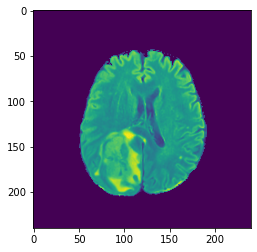

In [13]:
plt.imshow(img[90,:,:])

Text(0.5, 1.0, 'coronal kesit')

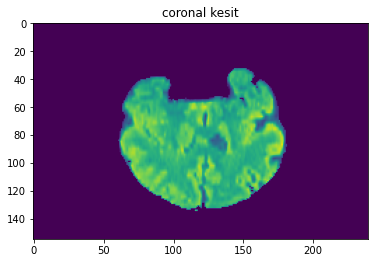

In [14]:
plt.imshow(img[:,90,:])
plt.title("coronal kesit")

Text(0.5, 1.0, 'segittal kesit')

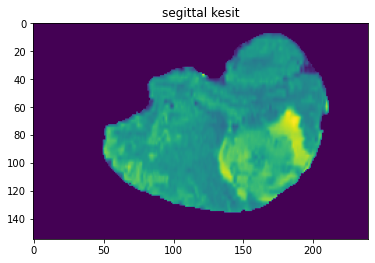

In [15]:
plt.imshow(img[:,:,90])
plt.title("segittal kesit")

In [16]:
örnek

'..//input//brain-tumor//MICCAI_BraTS2020_TrainingData/BraTS20_Training_337/BraTS20_Training_337_flair.nii'

In [17]:
img_seg =io.imread('..//input//brain-tumor//MICCAI_BraTS2020_TrainingData/BraTS20_Training_337/BraTS20_Training_337_seg.nii',plugin="simpleitk")

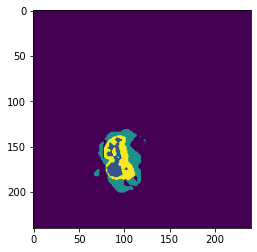

In [18]:
plt.imshow(img_seg[90,:,:])

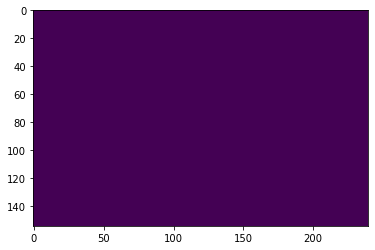

In [19]:
plt.imshow(img_seg[:,90,:])

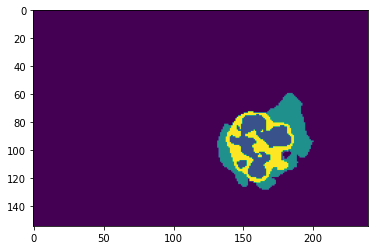

In [20]:
plt.imshow(img_seg[:,:,90])

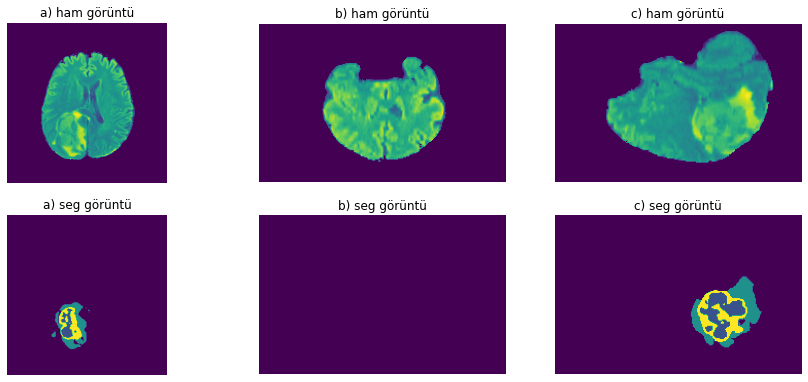

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(3,3,3)
plt.title('c) ham görüntü')
plt.axis('off')
plt.imshow(img[:,:,90])

plt.subplot(3,3,2)
plt.title('b) ham görüntü')
plt.axis('off')
plt.imshow(img[:,90,:])

plt.subplot(3,3,1)
plt.title('a) ham görüntü')
plt.axis('off')
plt.imshow(img[90,:,:])

plt.subplot(3,3,6)
plt.title('c) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[:,:,90])

plt.subplot(3,3,5)
plt.title('b) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[:,90,:])

plt.subplot(3,3,4)
plt.title('a) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[90,:,:])

In [22]:
import numpy as np
import random as r
import gc; gc.enable() # memory is tight

def train_array(path,end):
    files = glob.glob(path+end,recursive=True) # görüntülerin bulunduğu konumu glob modülü ile listeliyoruz
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files[70:130] :
        img = io.imread(file,plugin='simpleitk') # görüntüleri okuyoruz
        img = (img-img.mean())/img.std() # standartize ediyoruz
        img.astype('float32')
        
        # burada bazı görüntüler işimize yaramadığı için belli aralıkdaki görüntüleri aldık
        for slice in range(80,110):
            img_s = img[slice,:,:] # burada verimiz iki boyuta düştü
            img_s = np.expand_dims(img_s,axis=0)# Unet modeline üç boyutlu görüntü sokmamız gerektiğinden 
                                                # boyutunu tekrar artırıyoruz
            img_liste.append(img_s)
    return np.array(img_liste,np.float32)

In [23]:
a = img[61,:,:]
a.shape

(240, 240)

In [24]:
img.shape

(155, 240, 240)

In [25]:
örnek_a =np.expand_dims(a,axis=0)
örnek_a.shape

(1, 240, 240)

In [26]:
path="..//input//brain-tumor//MICCAI_BraTS2020_TrainingData//"
end="**//*flair.nii"

In [27]:
train = train_array(path,end)

In [28]:
train.shape

(1800, 1, 240, 240)

In [29]:
train_re =train[0].reshape(240,240)
train_re.shape

(240, 240)

In [30]:
train[0].shape

(1, 240, 240)

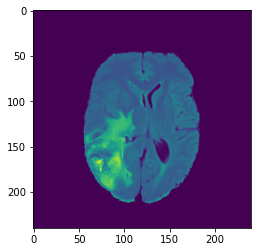

In [31]:
plt.imshow(train[1500].reshape(240,240))

# 1. Nekroz (Non-enhancing Tumor)
# 2. Ödem ( Edema ) 
# 4. Genişleyen tümor ( Enhancing Tumor )

In [32]:
img_seg.shape

(155, 240, 240)

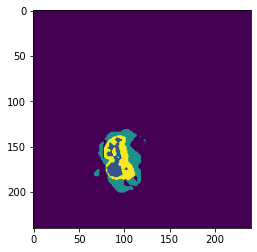

In [33]:
plt.imshow(img_seg[90,:,:])

In [34]:
seg_tam = img_seg.copy()

Text(0.5, 1.0, 'tam segmentasyon')

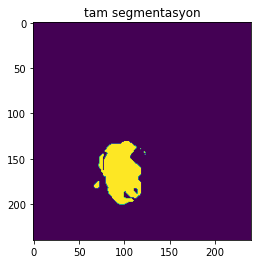

In [35]:
seg_tam[seg_tam != 0] = 1
plt.imshow(seg_tam[90,:,:])
plt.title('tam segmentasyon')

Text(0.5, 1.0, 'nekroz segmentasyon')

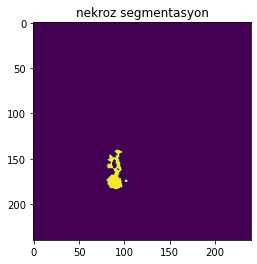

In [36]:
seg_nekroz = img_seg.copy()
seg_nekroz[seg_nekroz != 1] = 0
plt.imshow(seg_nekroz[90,:,:])
plt.title('nekroz segmentasyon')

Text(0.5, 1.0, 'ödem segmentasyon')

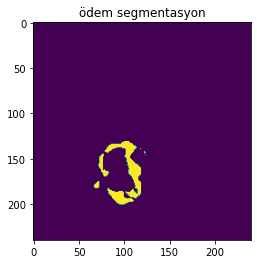

In [37]:
seg_ödem = img_seg.copy()
seg_ödem[seg_ödem == 1] = 0
seg_ödem[seg_ödem == 4] = 0
seg_ödem[seg_ödem != 0] = 1
plt.imshow(seg_ödem[90,:,:])
plt.title('ödem segmentasyon')

In [38]:
import numpy as np
import random as r
import gc; gc.enable() # memory is tight

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True) # görüntülerin bulunduğu konumu glob modülü ile listeliyoruz
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files[70:130] :
        img = io.imread(file,plugin='simpleitk') # görüntüleri okuyoruz
        
        if label == 1:
            img[img != 0] = 1 # Tam tümör
        if label == 2:
            img[img != 1] = 0 # Nekroz
        if label == 3:
            img[img == 2] = 0 # Ödemsiz tümör
            img[img != 0] = 1 
        if label == 4:
            img[img != 4] = 0 # Genişleyen tümör
            img[img == 4] = 1 
            
        img.astype('float32')
        
    
        # burada bazı görüntüler işimize yaramadığı için belli aralıkdaki görüntüleri aldık
        for slice in range(80,110):
            img_s = img[slice,:,:] # burada verimiz iki boyuta düştü
            img_s = np.expand_dims(img_s,axis=0)# Unet modeline üç boyutlu görüntü sokmamız gerektiğinden 
                                                # boyutunu tekrar artırıyoruz
            img_liste.append(img_s)
    print("img.shape",img.shape)
    return np.array(img_liste,np.float32)

In [39]:
path="..//input//brain-tumor//MICCAI_BraTS2020_TrainingData//"
end="**//*seg.nii"

In [40]:
seg_tam = seg_array(path,end,1)
seg_nekroz = seg_array(path,end,2)
seg_ödemsiz = seg_array(path,end,3)
seg_geniş = seg_array(path,end,4)
seg_orj = seg_array(path,end,0)

img.shape (155, 240, 240)
img.shape (155, 240, 240)
img.shape (155, 240, 240)
img.shape (155, 240, 240)
img.shape (155, 240, 240)


Text(0.5, 1.0, 'ham görüntü')

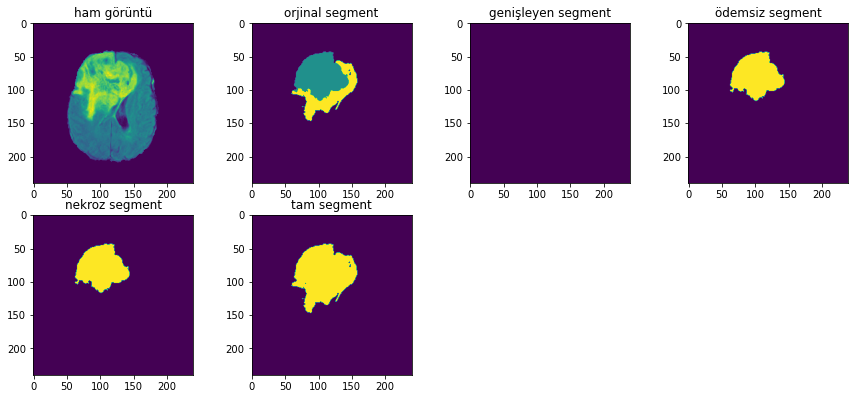

In [41]:
x=1352

plt.figure(figsize=(15,10))

plt.subplot(3,4,6)
plt.imshow(seg_tam[x].reshape(240,240))
plt.title("tam segment")

plt.subplot(3,4,5)
plt.imshow(seg_nekroz[x].reshape(240,240))
plt.title("nekroz segment")

plt.subplot(3,4,4)
plt.imshow(seg_ödemsiz[x].reshape(240,240))
plt.title("ödemsiz segment")

plt.subplot(3,4,3)
plt.imshow(seg_geniş[x].reshape(240,240))
plt.title("genişleyen segment")

plt.subplot(3,4,2)
plt.imshow(seg_orj[x].reshape(240,240))
plt.title("orjinal segment")

plt.subplot(3,4,1)
plt.imshow(train[x].reshape(240,240))
plt.title("ham görüntü")

In [42]:
seg_tam.shape

(1800, 1, 240, 240)

In [43]:
train.shape

(1800, 1, 240, 240)

# Modeli Oluşturma ve Eğitme

In [44]:
flair = train_array("..//input//brain-tumor//MICCAI_BraTS2020_TrainingData//","**//*flair.nii")
t2    = train_array("..//input//brain-tumor//MICCAI_BraTS2020_TrainingData//","**//*t2.nii")
seg   = seg_array("..//input//brain-tumor//MICCAI_BraTS2020_TrainingData//","**//*seg.nii",1)

img.shape (155, 240, 240)


In [45]:
flair.shape, t2.shape ,seg.shape

((1800, 1, 240, 240), (1800, 1, 240, 240), (1800, 1, 240, 240))

flair görüntülerin de tümorün merkezi daha iyi görünürken , t2 görüntülerinde ödem daha belirgin görünüyor bu yüzden bu iki görüntüyü birleştrip eğitime sokacağız.

In [46]:
x_train = np.concatenate((flair,t2),axis=1)

In [47]:
x_train.shape

(1800, 2, 240, 240)

# Model

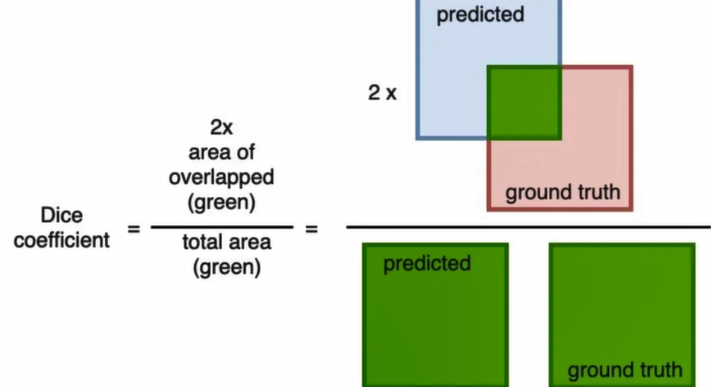

In [48]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    
    inputs = Input((2, 240 , 240))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [49]:
model = unet_model()

In [50]:
history = model.fit(x_train,
          seg,
          validation_split=0.20,
          batch_size=10,
          epochs=25,
          verbose=1)

Epoch 1/25
144/144 [==============================] - 41s 282ms/step - loss: 0.7967 - dice_coef: 0.2033 - val_loss: 0.8429 - val_dice_coef: 0.1571
Epoch 2/25
144/144 [==============================] - 40s 277ms/step - loss: 0.6766 - dice_coef: 0.3234 - val_loss: 0.8045 - val_dice_coef: 0.1955
Epoch 3/25
144/144 [==============================] - 40s 277ms/step - loss: 0.5928 - dice_coef: 0.4072 - val_loss: 0.7798 - val_dice_coef: 0.2202
Epoch 4/25
144/144 [==============================] - 40s 277ms/step - loss: 0.5414 - dice_coef: 0.4586 - val_loss: 0.7703 - val_dice_coef: 0.2297
Epoch 5/25
144/144 [==============================] - 40s 277ms/step - loss: 0.4715 - dice_coef: 0.5285 - val_loss: 0.7506 - val_dice_coef: 0.2494
Epoch 6/25
144/144 [==============================] - 40s 278ms/step - loss: 0.4275 - dice_coef: 0.5725 - val_loss: 0.7051 - val_dice_coef: 0.2949
Epoch 7/25
144/144 [==============================] - 40s 277ms/step - loss: 0.3605 - dice_coef: 0.6395 - val_loss: 0.

In [51]:
#score = model.evaluate(x=x_train,y=seg,batch_size=10)
#score
#print('Score Accuracy : {:.2f}%'.format(score[1]*100))

In [52]:
# list all data in history
#print(history.history.keys())

In [53]:
#eğitilen modelin ağırlıklarını kaydetme

model.save_weights("brain_tumor.h5")

In [54]:
#daha önce kaydedilenleri kod ekranına yukleme
model.load_weights("./brain_tumor.h5")

In [55]:
x_train.shape

(1800, 2, 240, 240)

In [56]:
x_train[400].shape

(2, 240, 240)

In [57]:
x_train[400][0].shape

(240, 240)

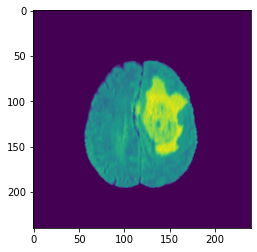

In [58]:
plt.imshow(x_train[500][0])#göruntuyu 2 boyuta dönusturme

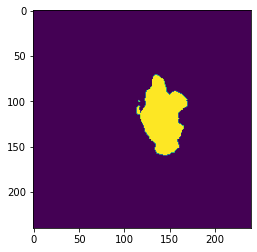

In [59]:
plt.imshow(seg[500][0])

In [60]:
#model tahmini için boyut çoğaltma işlemi

örnek = np.expand_dims(x_train[500],axis=0)

In [61]:
x_train[500].shape

(2, 240, 240)

In [62]:
örnek.shape

(1, 2, 240, 240)

In [63]:
pred = model.predict(örnek)

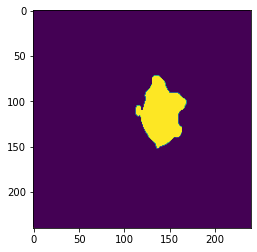

In [64]:
plt.imshow(pred[0][0])

In [65]:

def tahmin(x,a) :
    renk = {0:'magma',
            1:'viridis',
            2:'gray',
            3:'inferno',
            4:'cividis',
            5:'hot', }
    a    = a #cmap için yapılmış renk değişimleri tahmin ile bilgisayar arasındaki tahmini daha rahat gösterebilmek için.

    örnek = np.expand_dims(x_train[x],axis=0) #x değeri elimizdeki örnek verimizi temsil eder.
    pred = model.predict(örnek)

    #GÖRSELLEŞTİRME İŞLEMLERİ
    fig = plt.figure(figsize=(15,10))

    plt.subplot(141)
    plt.title('Input (Flair + T2)')
    plt.imshow(x_train[x][0],cmap = renk[a])

    plt.subplot(142)
    plt.title('Radiologist (segmentation)')
    plt.imshow( seg[x][0],cmap = renk[a])

    plt.subplot(143)
    plt.title('Bilgisayarın tahmini (Prediction)')
    return plt.imshow( pred[0][0],cmap = renk[a])

# Model tahmin sonuçları

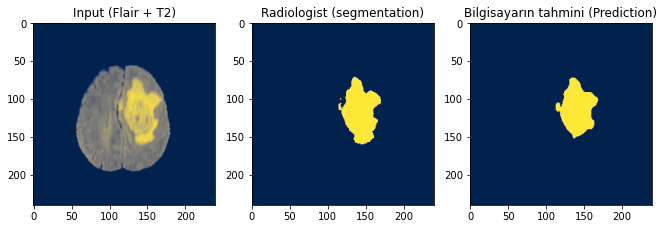

In [66]:
tahmin(500,4)

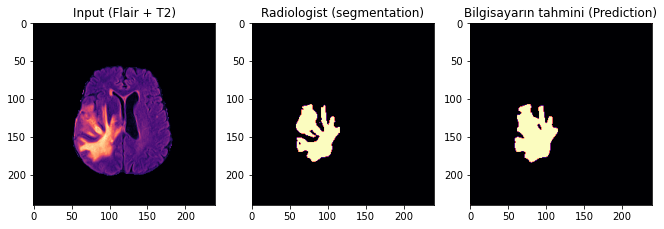

In [67]:
tahmin(1000,0)

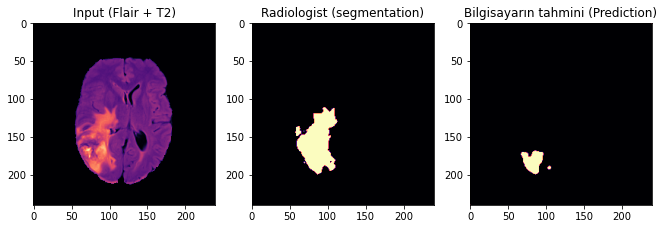

In [68]:
tahmin(1500,0)

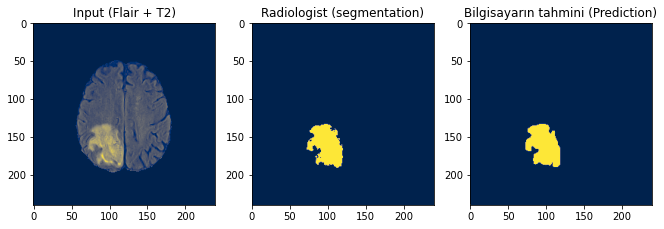

In [69]:
tahmin(650,4)

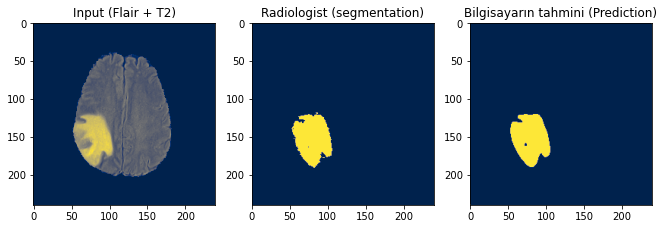

In [70]:
tahmin(950,4)

* # **Tümörlü kısımda kırpma işlemleri**

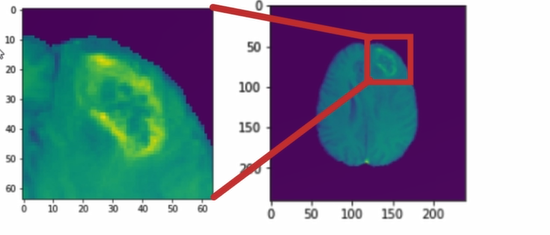

Text(0.5, 1.0, 'ham görüntü')

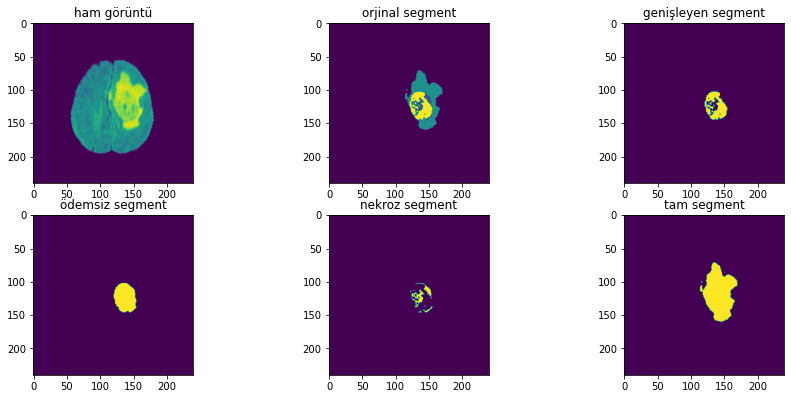

In [71]:
x=500

plt.figure(figsize=(15,10))

plt.subplot(3,3,6)
plt.imshow(seg_tam[x].reshape(240,240))
plt.title("tam segment")

plt.subplot(3,3,5)
plt.imshow(seg_nekroz[x].reshape(240,240))
plt.title("nekroz segment")

plt.subplot(3,3,4)
plt.imshow(seg_ödemsiz[x].reshape(240,240))
plt.title("ödemsiz segment")

plt.subplot(3,3,3)
plt.imshow(seg_geniş[x].reshape(240,240))
plt.title("genişleyen segment")

plt.subplot(3,3,2)
plt.imshow(seg_orj[x].reshape(240,240))
plt.title("orjinal segment")

plt.subplot(3,3,1)
plt.imshow(train[x].reshape(240,240))
plt.title("ham görüntü")

In [72]:
tmp = seg_ödemsiz[500,0,:,:]#Ödemsiz segment'ten 500 veriyi almak istedim
tmp.shape

(240, 240)

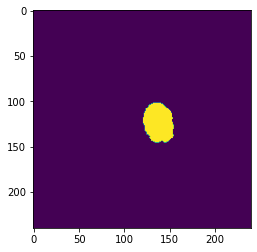

In [73]:
plt.imshow(tmp)

In [74]:
t1ce = train_array("..//input//brain-tumor//MICCAI_BraTS2020_TrainingData//","**//*t1ce.nii")

In [75]:
#Threshold işlemi 
tmp[tmp>0.2] = 1
tmp[tmp!= 1] = 0

In [76]:
#np.where tmp'nin 1 olduğu tum yerlerin konumunu bize index şeklinde verir.
index_xy = np.where(tmp==1)

In [77]:
#index_xy[0] dikey eksendeki indexleri verirken, index_xy[1] ise yatay eksendeki koordinatları verir.   

index_xy


(array([102, 102, 102, ..., 145, 145, 145]),
 array([132, 133, 134, ..., 144, 145, 146]))

In [78]:
#y ve x merkezini belirleme
merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2

In [79]:
merkez_y,merkez_x

(123.5, 137.5)

In [80]:
#modelin tam bir göruntu verebilmek için, sıfırlardan oluşan bir matris oluşturdum
img_x =  np.zeros((64,64), np.float32)

In [81]:
#bulduğumuz merkez noktaları ile t1ce göruntulerinde kırpma işlemi yapacağız.
x=t1ce[500,0,:,:]
x.shape

(240, 240)

In [82]:
img_x[:,:] = x[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]

(64, 64)

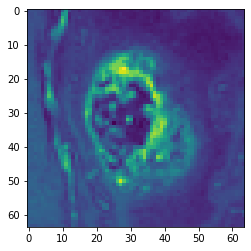

In [108]:
plt.imshow(img_x)
img_x.shape #64'e 64'luk tumor tespiti yapıldı.

In [85]:
def tümör_kırpma(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0
    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
        merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]
        liste.append(img_x)
        
    return np.array(liste)

In [86]:
t1ce_def = tümör_kırpma(t1ce[500],seg_ödemsiz[500])
nekroz_def = tümör_kırpma(seg_nekroz[500],seg_ödemsiz[500])
geniş_def = tümör_kırpma(seg_geniş[500],seg_ödemsiz[500])
ödemsiz_def = tümör_kırpma(seg_ödemsiz[500],seg_ödemsiz[500])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


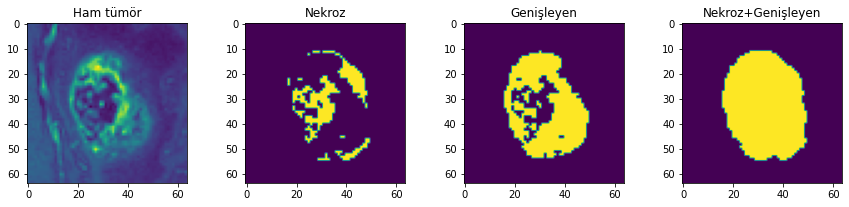

In [87]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title("Ham tümör")
plt.imshow(t1ce_def[0])

plt.subplot(3,4,2)
plt.title("Nekroz")
plt.imshow(nekroz_def[0])

plt.subplot(3,4,3)
plt.title("Genişleyen")
plt.imshow(geniş_def[0])

plt.subplot(3,4,4)
plt.title("Nekroz+Genişleyen")
plt.imshow(ödemsiz_def[0])

In [88]:
len(seg_ödemsiz)

1800

In [89]:
liste_ =[]
for i in range(len(seg_ödemsiz)):
    img = tümör_kırpma(seg_ödemsiz[i],seg_ödemsiz[i])
    if len(img.shape) > 2: #bazen veriler boş dönüyor hata çıkmaması için 
        liste_.append(img)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.


In [90]:
train_y=np.array(liste_)
train_y.shape

(967, 1, 64, 64)

In [91]:
train=np.array(liste_)

In [92]:
train.shape

(967, 1, 64, 64)

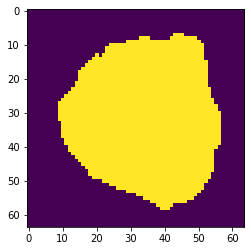

In [93]:
plt.imshow(train[15,0,:,:])

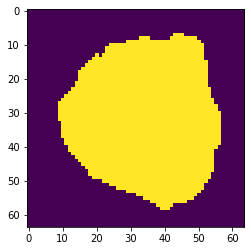

In [94]:
plt.imshow(train_y[15,0,:,:])

In [95]:
ödemsiz=np.array(liste_)

In [96]:
nekroz=np.array(liste_)

In [97]:
geniş=np.array(liste_)

In [98]:
t1ce=np.array(liste_)

In [99]:
t1ce.shape,ödemsiz.shape,geniş.shape,nekroz.shape

((967, 1, 64, 64), (967, 1, 64, 64), (967, 1, 64, 64), (967, 1, 64, 64))

# unet_model_7

In [100]:
#kırpılmış göruntuleri modele verme

def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model



In [101]:
model_ödemsiz = unet_model_7()

# Kırpılmış görüntülerin eğitimi

In [102]:
history = model_ödemsiz.fit(t1ce,
                        ödemsiz,
                       validation_split=0.20,
                        batch_size = 10,
                        epochs = 10,
                        shuffle = True,
                        verbose = 1
                       )

Epoch 1/10
78/78 [==============================] - 3s 33ms/step - loss: 0.1047 - dice_coef: 0.8956 - val_loss: 0.5988 - val_dice_coef: 0.3907
Epoch 2/10
78/78 [==============================] - 2s 23ms/step - loss: 0.0222 - dice_coef: 0.9763 - val_loss: 0.4470 - val_dice_coef: 0.5396
Epoch 3/10
78/78 [==============================] - 2s 24ms/step - loss: 0.0132 - dice_coef: 0.9868 - val_loss: 0.1117 - val_dice_coef: 0.8720
Epoch 4/10
78/78 [==============================] - 2s 23ms/step - loss: 0.0104 - dice_coef: 0.9897 - val_loss: 0.0333 - val_dice_coef: 0.9595
Epoch 5/10
78/78 [==============================] - 2s 24ms/step - loss: 0.0079 - dice_coef: 0.9919 - val_loss: 0.0136 - val_dice_coef: 0.9838
Epoch 6/10
78/78 [==============================] - 2s 24ms/step - loss: 0.0067 - dice_coef: 0.9933 - val_loss: 0.0072 - val_dice_coef: 0.9914
Epoch 7/10
78/78 [==============================] - 2s 23ms/step - loss: 0.0066 - dice_coef: 0.9920 - val_loss: 0.0046 - val_dice_coef: 0.9941

In [103]:
model_geniş=unet_model_7()

In [104]:
history = model_geniş.fit(t1ce,
                        geniş,
                        validation_split=0.20,
                        batch_size = 10,
                        epochs = 10,
                        shuffle = True,
                        verbose = 1
                       )

Epoch 1/10
78/78 [==============================] - 2s 27ms/step - loss: 0.1091 - dice_coef: 0.8900 - val_loss: 0.6623 - val_dice_coef: 0.3289
Epoch 2/10
78/78 [==============================] - 2s 23ms/step - loss: 0.0297 - dice_coef: 0.9702 - val_loss: 0.4844 - val_dice_coef: 0.5030
Epoch 3/10
78/78 [==============================] - 2s 23ms/step - loss: 0.0164 - dice_coef: 0.9837 - val_loss: 0.0720 - val_dice_coef: 0.9140
Epoch 4/10
78/78 [==============================] - 2s 24ms/step - loss: 0.0150 - dice_coef: 0.9851 - val_loss: 0.0265 - val_dice_coef: 0.9685
Epoch 5/10
78/78 [==============================] - 2s 23ms/step - loss: 0.0105 - dice_coef: 0.9895 - val_loss: 0.0117 - val_dice_coef: 0.9864
Epoch 6/10
78/78 [==============================] - 2s 23ms/step - loss: 0.0077 - dice_coef: 0.9923 - val_loss: 0.0059 - val_dice_coef: 0.9930
Epoch 7/10
78/78 [==============================] - 2s 23ms/step - loss: 0.0094 - dice_coef: 0.9907 - val_loss: 0.0029 - val_dice_coef: 0.9963

# kırpılmış görüntülerle tahmin

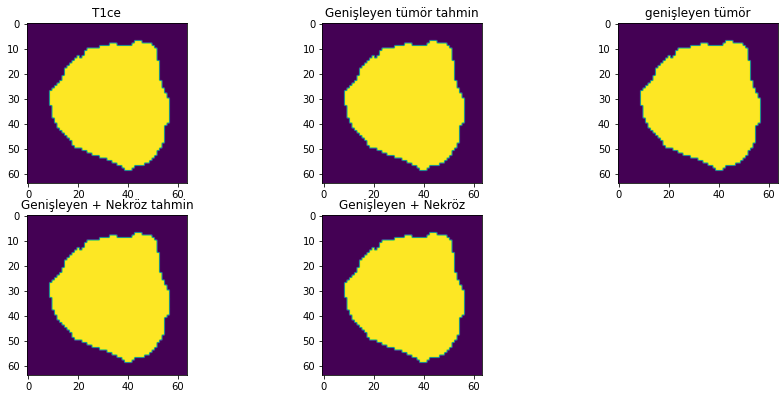

In [105]:
x = 15

plt.figure(figsize=(15,10))

plt.subplot(3,3,1)
plt.title("T1ce")
plt.imshow(t1ce[x,0,:,:])

pred_geniş = model_geniş.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,3,2)
plt.title("Genişleyen tümör tahmin")
plt.imshow(pred_geniş[0,0,:,:])

plt.subplot(3,3,3)
plt.title("genişleyen tümör")
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,3,4)
plt.title("Genişleyen + Nekröz tahmin")
plt.imshow(pred_ödemsiz[0,0,:,:])

plt.subplot(3,3,5)
plt.title("Genişleyen + Nekröz")
plt.imshow(ödemsiz[x,0,:,:])

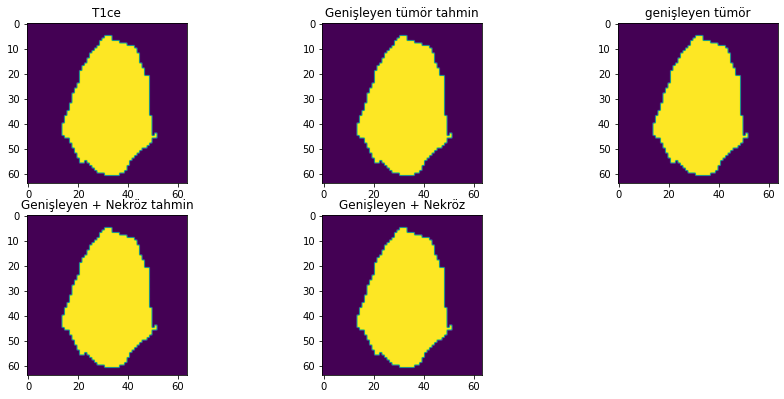

In [106]:
x = 45

plt.figure(figsize=(15,10))

plt.subplot(3,3,1)
plt.title("T1ce")
plt.imshow(t1ce[x,0,:,:])

pred_geniş = model_geniş.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,3,2)
plt.title("Genişleyen tümör tahmin")
plt.imshow(pred_geniş[0,0,:,:])

plt.subplot(3,3,3)
plt.title("genişleyen tümör")
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,3,4)
plt.title("Genişleyen + Nekröz tahmin")
plt.imshow(pred_ödemsiz[0,0,:,:])

plt.subplot(3,3,5)
plt.title("Genişleyen + Nekröz")
plt.imshow(ödemsiz[x,0,:,:])